# Distortion Classification

In [1]:
import torch
import torchaudio
import os

### Define transformation

In [2]:
SAMPLE_RATE = 22050
NUM_SAMPLES = 22050*3

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=512,
    hop_length=1050,
    n_mels=64,
    # power=2
)

spectrogram = torchaudio.transforms.Spectrogram(
    power=2,
    n_fft=127,
    win_length= 127,
    hop_length= 1040,
    normalized=True
)

mfcc = torchaudio.transforms.MFCC(
    sample_rate = SAMPLE_RATE, 
    n_mfcc = 64,
    melkwargs = {
        "n_fft": 1024,
        "hop_length": 1030,
        "n_mels": 64,
        "center": False})

#### Functions for training

In [3]:
from src.gtfxdataset import GtFxDataset
from src.util import plot_spectrogram
from src.extrector import train
from src.extrector import model
from torch import nn

AUDIO_DIR = "_assets/DATASET/GT-FX-C53/"
ANNOTATIONS_FILE = os.path.join(AUDIO_DIR, "annotation.csv")
EFFECT_MAP = ["distortion", "chorus", "tremolo", "delay", "reverb"]

def load_data(effect):
    
    fxData = GtFxDataset(ANNOTATIONS_FILE,
                        AUDIO_DIR,
                        mfcc,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device,
                        effect=EFFECT_MAP[effect])
    return fxData

def split_data(data):

    BATCH_SIZE = round(len(data) / 200)

    split_ratio = [0.8, 0.1, 0.1]
    train_set, test_set, val_set = torch.utils.data.random_split(data, lengths=split_ratio)

    train_dataloader = train.create_data_loader(train_set, BATCH_SIZE)
    test_dataloader = train.create_data_loader(test_set, BATCH_SIZE)
    val_dataloader = train.create_data_loader(val_set, BATCH_SIZE)

    return train_dataloader, test_dataloader, val_dataloader   

#### Add Tensorboard to record data

In [4]:
from torch.utils.tensorboard import SummaryWriter

EXPERIMENT_NAME = "c53_parameter"
LOG_DIR = "_log/" + EXPERIMENT_NAME

if not os.path.exists('%s' % LOG_DIR):
    os.makedirs('%s' % LOG_DIR)

log_writer = SummaryWriter(LOG_DIR)


#### Model training

Using device cpu
There are 4422 samples in the dataset.
Shape of signal: torch.Size([1, 64, 64])
input feature:


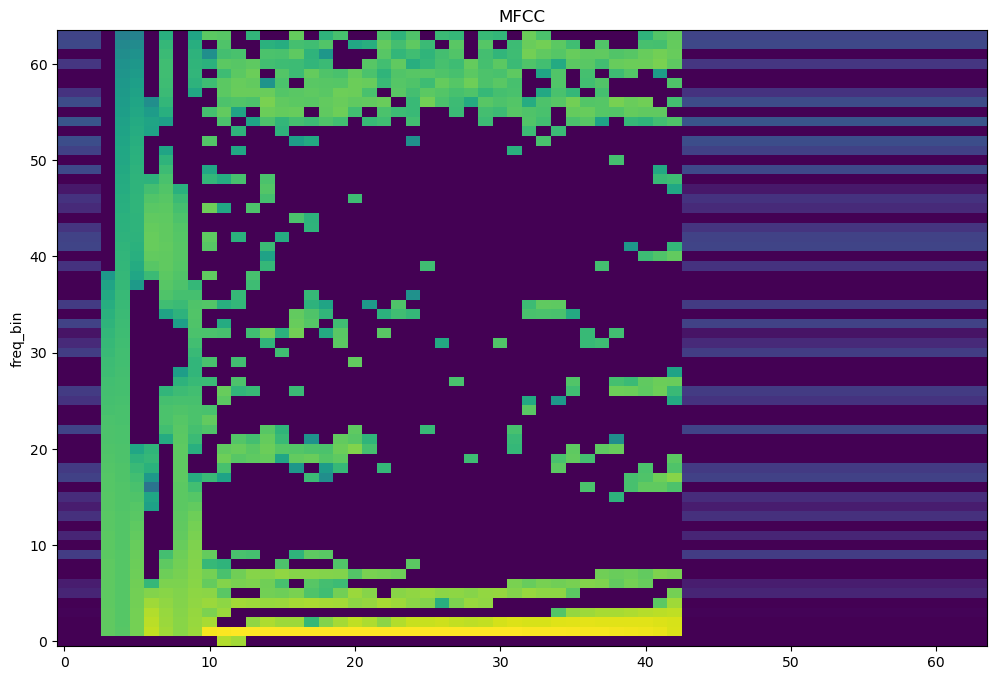

Epoch 1
loss: 0.059271  [  0/3538]
loss: 0.070694  [440/3538]
loss: 0.020724  [880/3538]
loss: 0.008610  [1320/3538]
loss: 0.005086  [1760/3538]
loss: 0.006320  [2200/3538]
loss: 0.006080  [2640/3538]
loss: 0.004661  [3080/3538]
loss: 0.006330  [3520/3538]
distortion: avg MSE: 0.002347, avg abs error: 0.0385
learning rate: 0.001000 -> 0.000910
---------------------------

Epoch 2
loss: 0.006156  [  0/3538]
loss: 0.003024  [440/3538]
loss: 0.003747  [880/3538]
loss: 0.017710  [1320/3538]
loss: 0.013031  [1760/3538]
loss: 0.001934  [2200/3538]
loss: 0.003350  [2640/3538]
loss: 0.000743  [3080/3538]
loss: 0.003363  [3520/3538]
distortion: avg MSE: 0.003090, avg abs error: 0.0426
learning rate: 0.000910 -> 0.000820
---------------------------

Epoch 3
loss: 0.001311  [  0/3538]
loss: 0.001977  [440/3538]
loss: 0.002363  [880/3538]
loss: 0.002589  [1320/3538]
loss: 0.001418  [1760/3538]
loss: 0.003824  [2200/3538]
loss: 0.003081  [2640/3538]
loss: 0.001413  [3080/3538]
loss: 0.004757  [3520

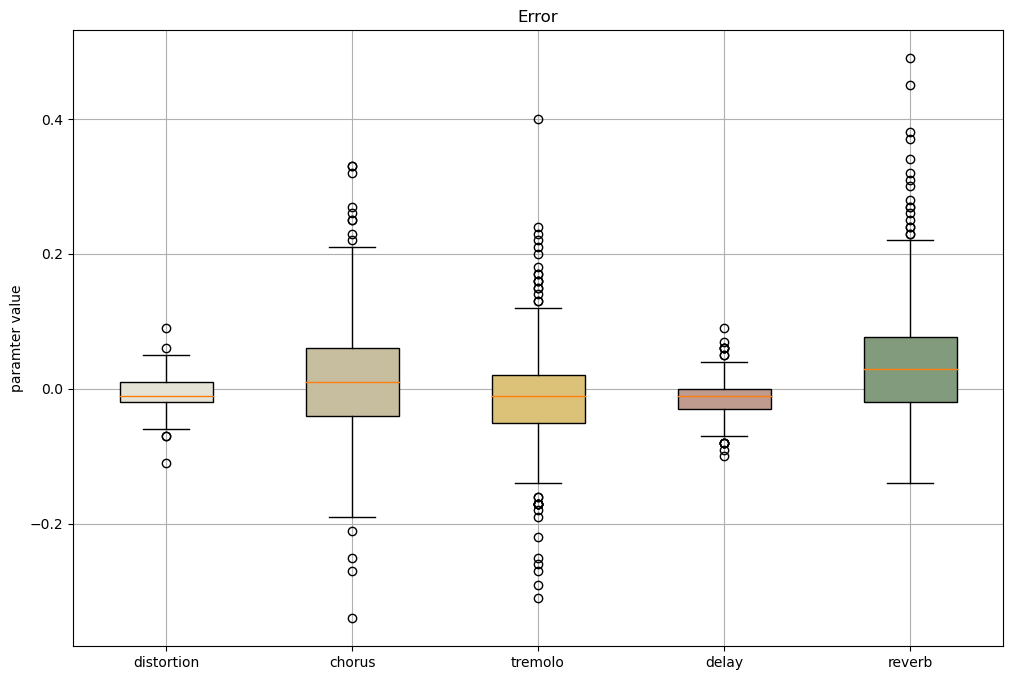

In [5]:
from src.util import plot_box

WEIGHTS_DIR = "_weights/"
LEARNING_RATE = 0.001
EPOCHS = 20



if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using device {device}")

error = [[], [], [], [], []]

for fx in range(5):

    fxData = load_data(fx)
    train_dataloader, test_dataloader, val_dataloader = split_data(fxData)
    
    # construct model and assign it to device
    cnn = model.Extractor().to(device)
    
    if fx == 0:
        signal, _, _, _, _ = fxData[0]
        print(f"There are {len(fxData)} samples in the dataset.")
        print(f"Shape of signal: {signal.shape}")

        print("input feature:")
        log_writer.add_figure("Input Feature", plot_spectrogram(signal[0], title="MFCC"))
        log_writer.add_graph(cnn, signal.unsqueeze_(0))

    # initialise loss funtion + optimiser
    loss_fn = nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

    # train model
    train.train(cnn,
                train_dataloader,
                test_dataloader,
                loss_fn,
                optimiser,
                device,
                log_writer,
                EPOCHS,
                effect=fx)

    _, _, log = train.test(cnn, val_dataloader, device, effect=fx)
    for _, data in enumerate(log):
        error[fx].append(data[3])

    WEIGHTS_FILE = os.path.join(WEIGHTS_DIR, EXPERIMENT_NAME + "_" + str(fx) + ".pth")

    if not os.path.exists('%s' % WEIGHTS_DIR):
        os.makedirs('%s' % WEIGHTS_DIR)

    # save model
    torch.save(cnn.state_dict(), WEIGHTS_FILE)
    print("Trained feed forward net saved at %s" %(WEIGHTS_FILE))

log_writer.add_figure("Error Box", 
                      plot_box(error, title="Error", labels=EFFECT_MAP, ylabel="paramter value"))

log_writer.close()